In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import tile3
import sys

def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

class MountainCar:
    def __init__(self):
        self.pxbound = (-1.2, 0.5)
        self.vxbound = (-0.07, 0.07)
        self.reset()

    def state_space(self):
        return (self.pxbound, self.vxbound)
    
    def action_shape(self):
        return 3
    
    def reset(self):
        self.px = random.random()*0.2 - 0.6        
        self.vx = 0
        return (self.px, self.vx)
    
    def step(self, action):
        assert(0 <= action and action <=2)
        acc = (action - 1.0)*0.001
        self.vx = clamp(self.vx + acc - 0.0025*math.cos(3 * self.px), *self.vxbound)
        self.px = clamp(self.px + self.vx, *self.pxbound)
        if self.px == self.pxbound[0]:
            self.vx = 0
        terminated = self.px == self.pxbound[1]
        return terminated, -1, (self.px, self.vx)

    def is_terminated(self, state):
        return self.px == self.pxbound[1]


class TileCodeing:
    def __init__(self, env):
        self.iht = tile3.IHT(4096)
        state_space = env.state_space()
        self.action_shape = env.action_shape()
        self.state_param = [8.0/(bound[1]-bound[0]) for bound in state_space]
        self.reset()

    def reset(self):
        self.w = np.zeros(4096)

    def to_features(self, state, action):
        floats = [s*p for s,p in zip(state, self.state_param)]
        tiles = tile3.tiles(self.iht, 8, floats, [action])
        return tiles

    def predicate(self, state, action):
        features = self.to_features(state, action)
        q_hat = self.w[features].sum()
        return q_hat

    def predicate_qs(self, state):
        qs = np.zeros(self.action_shape)
        for a in range(self.action_shape):
            qs[a] = self.predicate(state, a)
        return qs

    def train(self, state, action, target, alpha):
        features = self.to_features(state, action)
        q_hat = self.w[features].sum()
        self.w[features] += alpha * (target - q_hat)

def epsilon_greedy(qs, epsilon):
    if random.random() < epsilon:
        return random.choice(range(len(qs)))
    else:
        return qs.argmax()
    
def episodic_semi_gradient_sarsa(env, approximator, num_episodes, alpha, epsilon = 0.1, gamma = 1.0, max_step = sys.maxsize):
    step_stat = np.zeros(num_episodes, dtype=int)
    for episode in range(num_episodes):
        state = env.reset()
        qs = approximator.predicate_qs(state)
        action = epsilon_greedy(qs, epsilon)
        while True:
            max_step -= 1
            if 0 == max_step:
                return step_stat
            step_stat[episode] += 1
            terminated, reward, next_state = env.step(action)
            if env.is_terminated(next_state):
                approximator.train(state, action, reward, alpha)
                break
            else:
                qs_prime = approximator.predicate_qs(next_state)
                next_action = epsilon_greedy(qs_prime, epsilon)
                approximator.train(state, action, reward + qs_prime[next_action] * gamma, alpha)
                state = next_state
                action = next_action
            if terminated:
                break
    return step_stat



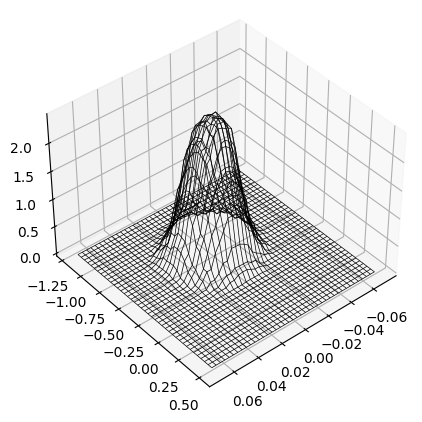

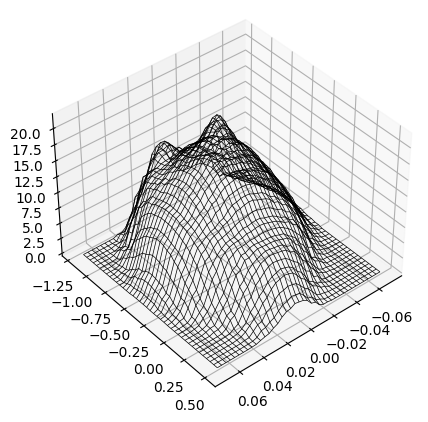

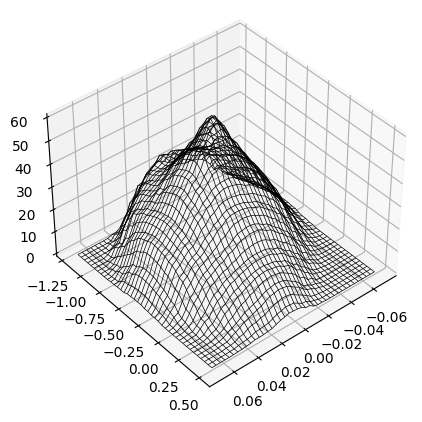

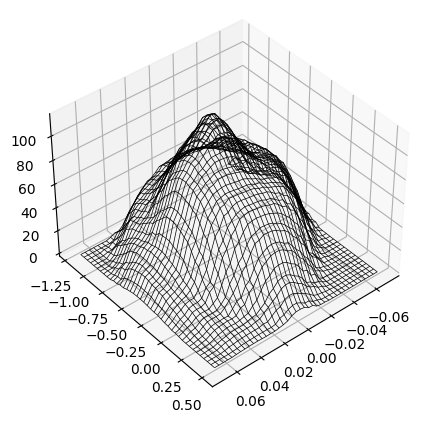

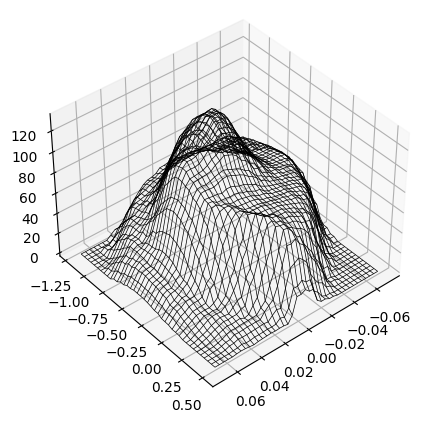

In [42]:
def lerp(a, b, s):
    return a + s*(b-a)


def show_values_3d(num_episodes, max_step = sys.maxsize):
    env = MountainCar()
    approximator = TileCodeing(env)
    step_stat = episodic_semi_gradient_sarsa(env, approximator, num_episodes, 0.1/8, max_step = max_step)

    segments = 40
    minus_max_qs = np.zeros((segments, segments))
    for p in range(segments):
        for v in range(segments):
            state = (lerp(*env.pxbound, p/(segments-1)), lerp(*env.vxbound, v/(segments-1)))
            minus_max_qs[p][v] = -approximator.predicate_qs(state).max()

    plt.rcParams['figure.figsize']=(5, 5)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    y = np.linspace(*env.pxbound,segments)
    x = np.linspace(*env.vxbound,segments)
    X, Y = np.meshgrid(x, y)
    ax.plot_wireframe(X, Y, minus_max_qs, color='black', linewidth=0.5)
    ax.view_init(40,50)

show_values_3d(1, 428)
show_values_3d(12)
show_values_3d(104)
show_values_3d(1000)
show_values_3d(9000)


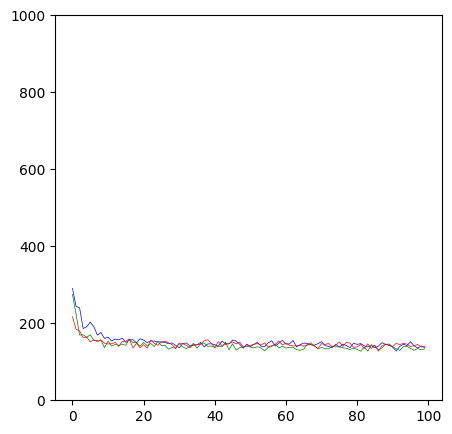

In [39]:
num_episodes = 100
num_avg = 20

params = [
    [0.1/8, "b"],
    [0.2/8, "g"],
    [0.5/8, "r"],
]

plt.ylim((0,1000))
for param in params:
    env = MountainCar()
    approximator = TileCodeing(env)
    alpha = param[0]
    style = param[1]
    avg_stat = np.zeros(num_episodes)
    for n in range(num_avg):
        step_stat = episodic_semi_gradient_sarsa(env, approximator, num_episodes, alpha)
        avg_stat += step_stat
    avg_stat /= num_avg
    plt.plot(range(len(avg_stat)), avg_stat, style, linewidth=0.5)

